In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing as prep
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
import re
from datetime import datetime

In [2]:
# Brining in data file
df = pd.read_csv('Uber Request Data.csv')

In [3]:
# Verifying import
df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


In [4]:
# Finding all possible outcomes for 'Status' column
df.Status.unique()

array(['Trip Completed', 'Cancelled', 'No Cars Available'], dtype=object)

In [5]:
# Replacing spaces in columns with underscores
df.columns = df.columns.str.replace(' ','_')
df.head()

,Request_id,Pickup_point,Driver_id,Status,Request_timestamp,Drop_timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


In [6]:
# Splitting Request_timestamp into individual columns
df[['Req_Date','Request_Time']] = df.Request_timestamp.str.split(" ",expand=True)
df.head()


,Request_id,Pickup_point,Driver_id,Status,Request_timestamp,Drop_timestamp,Req_Date,Request_Time
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00,11/7/2016,11:51
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47,11/7/2016,17:57
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58,12/7/2016,9:17
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03,12/7/2016,21:08
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47,13-07-2016,08:33:16


In [7]:
# Splitting Drop_timestamp into individual columns
df[['Drop_Date','Drop_Time']] = df.Drop_timestamp.str.split(" ",expand=True)
df.head()

,Request_id,Pickup_point,Driver_id,Status,Request_timestamp,Drop_timestamp,Req_Date,Request_Time,Drop_Date,Drop_Time
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00,11/7/2016,11:51,11/7/2016,13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47,11/7/2016,17:57,11/7/2016,18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58,12/7/2016,9:17,12/7/2016,9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03,12/7/2016,21:08,12/7/2016,22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47,13-07-2016,08:33:16,13-07-2016,09:25:47


In [8]:
# Dropping redundancy
df = df.drop(columns=['Request_timestamp', 'Drop_timestamp'])


In [9]:
# Converting status options to a mapped value, 1 = completed 2 = incomplete
outcomes = {
    'Trip Completed' : 1, 
    'No Cars Available' : 0, 
    'Cancelled' : 0, 
}

# Adding new column for mapped options
df['mapped_status_type'] = df['Status'].map(outcomes)

# Testing new column placement
df.head()

,Request_id,Pickup_point,Driver_id,Status,Req_Date,Request_Time,Drop_Date,Drop_Time,mapped_status_type
0,619,Airport,1.0,Trip Completed,11/7/2016,11:51,11/7/2016,13:00,1
1,867,Airport,1.0,Trip Completed,11/7/2016,17:57,11/7/2016,18:47,1
2,1807,City,1.0,Trip Completed,12/7/2016,9:17,12/7/2016,9:58,1
3,2532,Airport,1.0,Trip Completed,12/7/2016,21:08,12/7/2016,22:03,1
4,3112,City,1.0,Trip Completed,13-07-2016,08:33:16,13-07-2016,09:25:47,1


In [10]:
df.isnull().sum()

Request_id               0
Pickup_point             0
Driver_id             2650
Status                   0
Req_Date                 0
Request_Time             0
Drop_Date             3914
Drop_Time             3914
mapped_status_type       0
dtype: int64

### We will not be removing null values as those are crucial to the determination of "Status" in our model

In [11]:
df.Req_Date.apply(lambda x: pd.to_datetime(x).strftime('%m/%d/%y')[0])
df.head()

,Request_id,Pickup_point,Driver_id,Status,Req_Date,Request_Time,Drop_Date,Drop_Time,mapped_status_type
0,619,Airport,1.0,Trip Completed,11/7/2016,11:51,11/7/2016,13:00,1
1,867,Airport,1.0,Trip Completed,11/7/2016,17:57,11/7/2016,18:47,1
2,1807,City,1.0,Trip Completed,12/7/2016,9:17,12/7/2016,9:58,1
3,2532,Airport,1.0,Trip Completed,12/7/2016,21:08,12/7/2016,22:03,1
4,3112,City,1.0,Trip Completed,13-07-2016,08:33:16,13-07-2016,09:25:47,1


In [12]:
df.Req_Date.unique()

array(['11/7/2016', '12/7/2016', '13-07-2016', '14-07-2016', '15-07-2016'],
      dtype=object)

In [13]:
# Replacing hyphens with '/' in appropriate columns
pd.Series(['Req_Date', 'Drop_Date', np.nan]).str.replace('-', '/', regex=True)
df.head()

,Request_id,Pickup_point,Driver_id,Status,Req_Date,Request_Time,Drop_Date,Drop_Time,mapped_status_type
0,619,Airport,1.0,Trip Completed,11/7/2016,11:51,11/7/2016,13:00,1
1,867,Airport,1.0,Trip Completed,11/7/2016,17:57,11/7/2016,18:47,1
2,1807,City,1.0,Trip Completed,12/7/2016,9:17,12/7/2016,9:58,1
3,2532,Airport,1.0,Trip Completed,12/7/2016,21:08,12/7/2016,22:03,1
4,3112,City,1.0,Trip Completed,13-07-2016,08:33:16,13-07-2016,09:25:47,1


In [14]:
df.Req_Date.unique()

array(['11/7/2016', '12/7/2016', '13-07-2016', '14-07-2016', '15-07-2016'],
      dtype=object)

In [15]:
df.Req_Date.replace("-","/")
df.head()

,Request_id,Pickup_point,Driver_id,Status,Req_Date,Request_Time,Drop_Date,Drop_Time,mapped_status_type
0,619,Airport,1.0,Trip Completed,11/7/2016,11:51,11/7/2016,13:00,1
1,867,Airport,1.0,Trip Completed,11/7/2016,17:57,11/7/2016,18:47,1
2,1807,City,1.0,Trip Completed,12/7/2016,9:17,12/7/2016,9:58,1
3,2532,Airport,1.0,Trip Completed,12/7/2016,21:08,12/7/2016,22:03,1
4,3112,City,1.0,Trip Completed,13-07-2016,08:33:16,13-07-2016,09:25:47,1


In [16]:
# Converting all request date formats to be the same
df['Req_Date'] = pd.to_datetime(df.Req_Date)
df['Req_Date'] = df['Req_Date'].dt.strftime('%m/%d/%Y')
df.head()

,Request_id,Pickup_point,Driver_id,Status,Req_Date,Request_Time,Drop_Date,Drop_Time,mapped_status_type
0,619,Airport,1.0,Trip Completed,11/07/2016,11:51,11/7/2016,13:00,1
1,867,Airport,1.0,Trip Completed,11/07/2016,17:57,11/7/2016,18:47,1
2,1807,City,1.0,Trip Completed,12/07/2016,9:17,12/7/2016,9:58,1
3,2532,Airport,1.0,Trip Completed,12/07/2016,21:08,12/7/2016,22:03,1
4,3112,City,1.0,Trip Completed,07/13/2016,08:33:16,13-07-2016,09:25:47,1


In [17]:
# Converting all drop date formats to be the same
df['Drop_Date'] = pd.to_datetime(df.Req_Date)
df['Drop_Date'] = df['Drop_Date'].dt.strftime('%m/%d/%Y')
df.head()

,Request_id,Pickup_point,Driver_id,Status,Req_Date,Request_Time,Drop_Date,Drop_Time,mapped_status_type
0,619,Airport,1.0,Trip Completed,11/07/2016,11:51,11/07/2016,13:00,1
1,867,Airport,1.0,Trip Completed,11/07/2016,17:57,11/07/2016,18:47,1
2,1807,City,1.0,Trip Completed,12/07/2016,9:17,12/07/2016,9:58,1
3,2532,Airport,1.0,Trip Completed,12/07/2016,21:08,12/07/2016,22:03,1
4,3112,City,1.0,Trip Completed,07/13/2016,08:33:16,07/13/2016,09:25:47,1


In [18]:
# Converting request time to string
Request_Time = df.Request_Time.astype(str).str.zfill(4)
Drop_Time = df.Drop_Time.astype(str).str.zfill(4)

In [19]:
df.head()

,Request_id,Pickup_point,Driver_id,Status,Req_Date,Request_Time,Drop_Date,Drop_Time,mapped_status_type
0,619,Airport,1.0,Trip Completed,11/07/2016,11:51,11/07/2016,13:00,1
1,867,Airport,1.0,Trip Completed,11/07/2016,17:57,11/07/2016,18:47,1
2,1807,City,1.0,Trip Completed,12/07/2016,9:17,12/07/2016,9:58,1
3,2532,Airport,1.0,Trip Completed,12/07/2016,21:08,12/07/2016,22:03,1
4,3112,City,1.0,Trip Completed,07/13/2016,08:33:16,07/13/2016,09:25:47,1


In [20]:
# Splitting time into three columns so we can convert all entries to same format
df[['ReqHour','ReqMinute','RegSecond']] = df['Request_Time'].str.split(':',expand=True)


In [21]:
df.head()

,Request_id,Pickup_point,Driver_id,Status,Req_Date,Request_Time,Drop_Date,Drop_Time,mapped_status_type,ReqHour,ReqMinute,RegSecond
0,619,Airport,1.0,Trip Completed,11/07/2016,11:51,11/07/2016,13:00,1,11,51,None
1,867,Airport,1.0,Trip Completed,11/07/2016,17:57,11/07/2016,18:47,1,17,57,None
2,1807,City,1.0,Trip Completed,12/07/2016,9:17,12/07/2016,9:58,1,9,17,None
3,2532,Airport,1.0,Trip Completed,12/07/2016,21:08,12/07/2016,22:03,1,21,08,None
4,3112,City,1.0,Trip Completed,07/13/2016,08:33:16,07/13/2016,09:25:47,1,08,33,16


In [22]:
# Aggregating Hour and Minute as seconds is not neccesary to our project
df['Req_Time'] = df[['ReqHour','ReqMinute']].agg(':'.join, axis=1)


df.head()

,Request_id,Pickup_point,Driver_id,Status,Req_Date,Request_Time,Drop_Date,Drop_Time,mapped_status_type,ReqHour,ReqMinute,RegSecond,Req_Time
0,619,Airport,1.0,Trip Completed,11/07/2016,11:51,11/07/2016,13:00,1,11,51,None,11:51
1,867,Airport,1.0,Trip Completed,11/07/2016,17:57,11/07/2016,18:47,1,17,57,None,17:57
2,1807,City,1.0,Trip Completed,12/07/2016,9:17,12/07/2016,9:58,1,9,17,None,9:17
3,2532,Airport,1.0,Trip Completed,12/07/2016,21:08,12/07/2016,22:03,1,21,08,None,21:08
4,3112,City,1.0,Trip Completed,07/13/2016,08:33:16,07/13/2016,09:25:47,1,08,33,16,08:33


In [23]:
# Dropping old request time column
df = df.drop('Request_Time', 1)


In [24]:
# Dropping split hour column
df = df.drop('ReqHour', 1)

In [25]:
# Dropping split minute column
df = df.drop('ReqMinute', 1)

In [26]:
# Dropping split second column
df = df.drop('RegSecond', 1)

In [27]:
# Verifying df format is accurate
df.head()

,Request_id,Pickup_point,Driver_id,Status,Req_Date,Drop_Date,Drop_Time,mapped_status_type,Req_Time
0,619,Airport,1.0,Trip Completed,11/07/2016,11/07/2016,13:00,1,11:51
1,867,Airport,1.0,Trip Completed,11/07/2016,11/07/2016,18:47,1,17:57
2,1807,City,1.0,Trip Completed,12/07/2016,12/07/2016,9:58,1,9:17
3,2532,Airport,1.0,Trip Completed,12/07/2016,12/07/2016,22:03,1,21:08
4,3112,City,1.0,Trip Completed,07/13/2016,07/13/2016,09:25:47,1,08:33


In [28]:
# Re-mapping column locations for organization
df = df[['Request_id','Pickup_point','Status','mapped_status_type','Req_Date','Req_Time','Drop_Date','Drop_Time']]

In [29]:

df.head()

,Request_id,Pickup_point,Status,mapped_status_type,Req_Date,Req_Time,Drop_Date,Drop_Time
0,619,Airport,Trip Completed,1,11/07/2016,11:51,11/07/2016,13:00
1,867,Airport,Trip Completed,1,11/07/2016,17:57,11/07/2016,18:47
2,1807,City,Trip Completed,1,12/07/2016,9:17,12/07/2016,9:58
3,2532,Airport,Trip Completed,1,12/07/2016,21:08,12/07/2016,22:03
4,3112,City,Trip Completed,1,07/13/2016,08:33,07/13/2016,09:25:47


In [30]:
import datetime
def is_weekday(dt):
    dow = datetime.datetime.strptime(dt, '%m/%d/%Y').isoweekday()
    if dow == 6 or dow == 7:
        return 0
    else:
        return 1

In [31]:
df['is_weekday'] = df['Req_Date'].apply(lambda x: is_weekday(x))
df.head()

,Request_id,Pickup_point,Status,mapped_status_type,Req_Date,Req_Time,Drop_Date,Drop_Time,is_weekday
0,619,Airport,Trip Completed,1,11/07/2016,11:51,11/07/2016,13:00,1
1,867,Airport,Trip Completed,1,11/07/2016,17:57,11/07/2016,18:47,1
2,1807,City,Trip Completed,1,12/07/2016,9:17,12/07/2016,9:58,1
3,2532,Airport,Trip Completed,1,12/07/2016,21:08,12/07/2016,22:03,1
4,3112,City,Trip Completed,1,07/13/2016,08:33,07/13/2016,09:25:47,1


In [32]:
df.head()

,Request_id,Pickup_point,Status,mapped_status_type,Req_Date,Req_Time,Drop_Date,Drop_Time,is_weekday
0,619,Airport,Trip Completed,1,11/07/2016,11:51,11/07/2016,13:00,1
1,867,Airport,Trip Completed,1,11/07/2016,17:57,11/07/2016,18:47,1
2,1807,City,Trip Completed,1,12/07/2016,9:17,12/07/2016,9:58,1
3,2532,Airport,Trip Completed,1,12/07/2016,21:08,12/07/2016,22:03,1
4,3112,City,Trip Completed,1,07/13/2016,08:33,07/13/2016,09:25:47,1


In [33]:
df[['DropHour','DropMinute','DropSeconds']] = df['Drop_Time'].str.split(':',expand=True)


In [34]:
df.head()

,Request_id,Pickup_point,Status,mapped_status_type,Req_Date,Req_Time,Drop_Date,Drop_Time,is_weekday,DropHour,DropMinute,DropSeconds
0,619,Airport,Trip Completed,1,11/07/2016,11:51,11/07/2016,13:00,1,13,00,None
1,867,Airport,Trip Completed,1,11/07/2016,17:57,11/07/2016,18:47,1,18,47,None
2,1807,City,Trip Completed,1,12/07/2016,9:17,12/07/2016,9:58,1,9,58,None
3,2532,Airport,Trip Completed,1,12/07/2016,21:08,12/07/2016,22:03,1,22,03,None
4,3112,City,Trip Completed,1,07/13/2016,08:33,07/13/2016,09:25:47,1,09,25,47


In [35]:
df = df.drop('Drop_Time', 1)


In [36]:
df['Drop_Time'] = [':'.join(str(x) for x in y) for y in map(tuple, df[['DropHour', 'DropMinute']].values)]
df.head()

,Request_id,Pickup_point,Status,mapped_status_type,Req_Date,Req_Time,Drop_Date,is_weekday,DropHour,DropMinute,DropSeconds,Drop_Time
0,619,Airport,Trip Completed,1,11/07/2016,11:51,11/07/2016,1,13,00,None,13:00
1,867,Airport,Trip Completed,1,11/07/2016,17:57,11/07/2016,1,18,47,None,18:47
2,1807,City,Trip Completed,1,12/07/2016,9:17,12/07/2016,1,9,58,None,9:58
3,2532,Airport,Trip Completed,1,12/07/2016,21:08,12/07/2016,1,22,03,None,22:03
4,3112,City,Trip Completed,1,07/13/2016,08:33,07/13/2016,1,09,25,47,09:25


In [37]:
# Dropping split columns for Drop
df = df.drop('DropHour', 1)
df = df.drop('DropMinute', 1)
df = df.drop('DropSeconds', 1)

In [38]:
# Re-mapping column to organize again
df = df[['Pickup_point','Status','mapped_status_type','Req_Date', 'is_weekday','Req_Time','Drop_Date','Drop_Time']]
df.head()

,Pickup_point,Status,mapped_status_type,Req_Date,is_weekday,Req_Time,Drop_Date,Drop_Time
0,Airport,Trip Completed,1,11/07/2016,1,11:51,11/07/2016,13:00
1,Airport,Trip Completed,1,11/07/2016,1,17:57,11/07/2016,18:47
2,City,Trip Completed,1,12/07/2016,1,9:17,12/07/2016,9:58
3,Airport,Trip Completed,1,12/07/2016,1,21:08,12/07/2016,22:03
4,City,Trip Completed,1,07/13/2016,1,08:33,07/13/2016,09:25


In [39]:
# Adding function to determine time of day


df['Req_TOD'] = pd.to_datetime(df['Req_Time'])
def tod(x):
    if (x>=1800) & (x<2200):
        tod = 'evening'
    elif (x>=500) & (x<1200):
        tod = 'morning'
    elif (x>=1200) & (x<1800):
        tod = 'afternoon'
    else:
        tod = 'Night'
    return tod

In [40]:
df = df[['Pickup_point','Status','mapped_status_type','Req_Date', 'is_weekday','Req_Time','Req_TOD','Drop_Date','Drop_Time']]
df.head()

,Pickup_point,Status,mapped_status_type,Req_Date,is_weekday,Req_Time,Req_TOD,Drop_Date,Drop_Time
0,Airport,Trip Completed,1,11/07/2016,1,11:51,2022-04-05 11:51:00,11/07/2016,13:00
1,Airport,Trip Completed,1,11/07/2016,1,17:57,2022-04-05 17:57:00,11/07/2016,18:47
2,City,Trip Completed,1,12/07/2016,1,9:17,2022-04-05 09:17:00,12/07/2016,9:58
3,Airport,Trip Completed,1,12/07/2016,1,21:08,2022-04-05 21:08:00,12/07/2016,22:03
4,City,Trip Completed,1,07/13/2016,1,08:33,2022-04-05 08:33:00,07/13/2016,09:25


In [41]:
df = df.astype({"Req_TOD": str})


In [42]:
df[['DateThrowAway', 'Req_TODna']] = df['Req_TOD'].str.split(' ', 1, expand=True)


In [43]:
df = df.drop('Req_TOD', 1)
df = df.drop('DateThrowAway', 1)

In [44]:
df.Req_TOD = df.Req_TODna

<ipython-input-44-9e9bfcaadf57>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Req_TOD = df.Req_TODna


In [45]:
df.head()

,Pickup_point,Status,mapped_status_type,Req_Date,is_weekday,Req_Time,Drop_Date,Drop_Time,Req_TODna
0,Airport,Trip Completed,1,11/07/2016,1,11:51,11/07/2016,13:00,11:51:00
1,Airport,Trip Completed,1,11/07/2016,1,17:57,11/07/2016,18:47,17:57:00
2,City,Trip Completed,1,12/07/2016,1,9:17,12/07/2016,9:58,09:17:00
3,Airport,Trip Completed,1,12/07/2016,1,21:08,12/07/2016,22:03,21:08:00
4,City,Trip Completed,1,07/13/2016,1,08:33,07/13/2016,09:25,08:33:00


In [46]:
df.rename(columns={'Req_TODna': 'Req_TOD'}, inplace=True)
df.head()

,Pickup_point,Status,mapped_status_type,Req_Date,is_weekday,Req_Time,Drop_Date,Drop_Time,Req_TOD
0,Airport,Trip Completed,1,11/07/2016,1,11:51,11/07/2016,13:00,11:51:00
1,Airport,Trip Completed,1,11/07/2016,1,17:57,11/07/2016,18:47,17:57:00
2,City,Trip Completed,1,12/07/2016,1,9:17,12/07/2016,9:58,09:17:00
3,Airport,Trip Completed,1,12/07/2016,1,21:08,12/07/2016,22:03,21:08:00
4,City,Trip Completed,1,07/13/2016,1,08:33,07/13/2016,09:25,08:33:00


In [47]:
df = df[['Pickup_point','Status','mapped_status_type','Req_Date', 'is_weekday','Req_Time','Req_TOD','Drop_Date','Drop_Time']]

df.head()

,Pickup_point,Status,mapped_status_type,Req_Date,is_weekday,Req_Time,Req_TOD,Drop_Date,Drop_Time
0,Airport,Trip Completed,1,11/07/2016,1,11:51,11:51:00,11/07/2016,13:00
1,Airport,Trip Completed,1,11/07/2016,1,17:57,17:57:00,11/07/2016,18:47
2,City,Trip Completed,1,12/07/2016,1,9:17,09:17:00,12/07/2016,9:58
3,Airport,Trip Completed,1,12/07/2016,1,21:08,21:08:00,12/07/2016,22:03
4,City,Trip Completed,1,07/13/2016,1,08:33,08:33:00,07/13/2016,09:25


In [48]:
df.Req_Time = df.Req_Time.str.replace('[:]', '')

In [49]:
df['Req_Time'] = df['Req_Time'].astype('int')

df['Req_TOD'] = df['Req_Time'].apply(lambda x: tod(x))
df.head()


,Pickup_point,Status,mapped_status_type,Req_Date,is_weekday,Req_Time,Req_TOD,Drop_Date,Drop_Time
0,Airport,Trip Completed,1,11/07/2016,1,1151,morning,11/07/2016,13:00
1,Airport,Trip Completed,1,11/07/2016,1,1757,afternoon,11/07/2016,18:47
2,City,Trip Completed,1,12/07/2016,1,917,morning,12/07/2016,9:58
3,Airport,Trip Completed,1,12/07/2016,1,2108,evening,12/07/2016,22:03
4,City,Trip Completed,1,07/13/2016,1,833,morning,07/13/2016,09:25


### Descriptive Statistcs

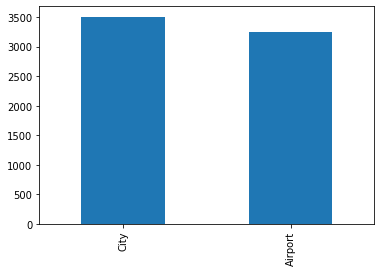

In [50]:
df['Pickup_point'].value_counts().plot(kind='bar')

#### The distribution between city and airport is pretty fair and prevents biases from one point to another. 

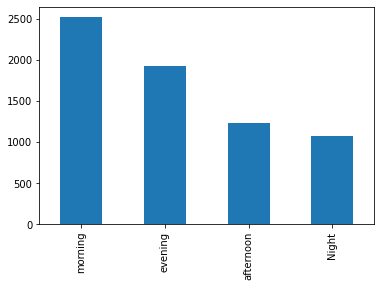

In [51]:
df['Req_TOD'].value_counts().plot(kind='bar')

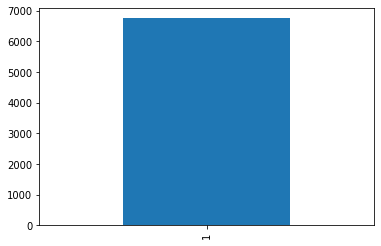

In [52]:
df['is_weekday'].value_counts().plot(kind='bar')

#### function needs to be altered, causing a false output!!

In [59]:
df.query('is_weekday == 0')

,Pickup_point,Status,mapped_status_type,Req_Date,is_weekday,Req_Time,Req_TOD,Drop_Date,Drop_Time


In [60]:
df.describe()

,mapped_status_type,is_weekday,Req_Time
count,6745.000000,6745.0,6745.000000
mean,0.419718,1.0,1325.245219
std,0.493549,0.0,650.217142
min,0.000000,1.0,0.000000
25%,0.000000,1.0,739.000000
50%,0.000000,1.0,1332.000000
75%,1.000000,1.0,1926.000000
max,1.000000,1.0,2359.000000


In [61]:
df.head()

,Pickup_point,Status,mapped_status_type,Req_Date,is_weekday,Req_Time,Req_TOD,Drop_Date,Drop_Time
0,Airport,Trip Completed,1,11/07/2016,1,1151,morning,11/07/2016,13:00
1,Airport,Trip Completed,1,11/07/2016,1,1757,afternoon,11/07/2016,18:47
2,City,Trip Completed,1,12/07/2016,1,917,morning,12/07/2016,9:58
3,Airport,Trip Completed,1,12/07/2016,1,2108,evening,12/07/2016,22:03
4,City,Trip Completed,1,07/13/2016,1,833,morning,07/13/2016,09:25


In [67]:
df.dtypes

Pickup_point          object
Status                object
mapped_status_type     int64
Req_Date              object
is_weekday             int64
Req_Time               int64
Req_TOD               object
Drop_Date             object
Drop_Time             object
dtype: object

In [68]:
df.shape

(6745, 9)